В этом ноутбуке исследуется качество четырех моделей (GaussianCopula, CTGAN, CopulaGAN, TVAE) генерации синтетических данных применительно к задаче генерации синтетических профилей пользователей из датасета MovieLens.

In [3]:
import os
# os.environ["CUDA_VISIBLE_DEVICES"]=""

import pandas as pd
import numpy as np

from pyspark import SparkConf
from pyspark.sql import SparkSession
import pyspark.sql.functions as sf

from replay.session_handler import State

from simulator.utils import pandas_to_spark

%matplotlib inline
import matplotlib.pyplot as plt

spark = SparkSession.builder\
    .appName('simulator_movielens')\
    .master('local[8]')\
    .config('spark.sql.shuffle.partitions', '8')\
    .config('spark.default.parallelism', '8')\
    .config('spark.driver.extraJavaOptions', '-XX:+UseG1GC')\
    .config('spark.executor.extraJavaOptions', '-XX:+UseG1GC')\
    .config('spark.sql.autoBroadcastJoinThreshold', '-1')\
    .config('spark.driver.memory', '128g')\
    .config('spark.local.dir', './tmp')\
    .getOrCreate()

State(spark)

/data/home/estavinova/.conda/envs/SynEvaRec/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
22/10/18 11:09:42 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/10/18 11:09:43 WARN SparkConf: Note that spark.local.dir will be overridden by the value set by the cluster manager (via SPARK_LOCAL_DIRS in mesos/standalone/kubernetes and LOCAL_DIRS in YARN).
22/10/18 11:09:45 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
22/10/18 11:09:45 WARN Utils: Service 'SparkUI' could not bind on port 404

# Read data

Работаем с предобработанными данными, которые разделены на три части по времени выставления рейтинга. Оценки 1 и 2 считаем отрицательными (0); 3, 4 и 5 -- положительными (1).

Данные были предварительно предобработаны (код в папке Movielens): составлены профили польззователей и предложений по истории откликов, а также данные разделены по времени выставления оценок на обучающую, валидационную и тестовую выборки.

In [4]:
DATA_PATH = r'file:///data/home/estavinova/simulator/data/Movielens/'

In [5]:
import pyspark.sql.types as st

USER_PREFIX = 'user_'
ITEM_PREFIX = 'item_'

USER_SCHEMA = st.StructType(
    [st.StructField('user_idx', st.IntegerType())] +\
    [st.StructField(f'genre{i}', st.DoubleType()) for i in range(19)] +\
    [st.StructField('rating_avg', st.DoubleType())] +\
    [st.StructField(f'w2v_{i}', st.DoubleType()) for i in range(300)]
)
ITEM_SCHEMA = st.StructType(
    [st.StructField('item_idx', st.IntegerType())] +\
    [st.StructField('year', st.IntegerType())] +\
    [st.StructField('rating_avg', st.DoubleType())] +\
    [st.StructField(f'genre{i}', st.DoubleType()) for i in range(19)] +\
    [st.StructField(f'w2v_{i}', st.DoubleType()) for i in range(300)]
)
LOG_SCHEMA = st.StructType([
    st.StructField('user_idx', st.IntegerType()),
    st.StructField('item_idx', st.IntegerType()),
    st.StructField('relevance', st.DoubleType()),
    st.StructField('timestamp', st.IntegerType())
])

users_df_train = spark.read.csv(DATA_PATH+'train/users.csv', header=True, schema=USER_SCHEMA)
items_df_train = spark.read.csv(DATA_PATH+'train/items.csv', header=True, schema=ITEM_SCHEMA)
log_df_train   = spark.read.csv(DATA_PATH+'train/rating.csv', header=True, schema=LOG_SCHEMA)

log_df_train = log_df_train.join(users_df_train, log_df_train['user_idx'] == users_df_train['user_idx'], 'leftsemi')
log_df_train = log_df_train.join(items_df_train, log_df_train['item_idx'] == items_df_train['item_idx'], 'leftsemi')

for c in users_df_train.columns[1:]:
    users_df_train = users_df_train.withColumnRenamed(c, 'user_' + c)
    
for c in items_df_train.columns[1:]:
    items_df_train = items_df_train.withColumnRenamed(c, 'item_' + c)

log_df_train = log_df_train.withColumn(
    'relevance', sf.when(sf.col('relevance') >= 3, 1).otherwise(0))

users_df_train = users_df_train.cache()
items_df_train = items_df_train.cache()
log_df_train = log_df_train.cache()

users_df_train.count()
items_df_train.count()
log_df_train.count()

22/10/18 11:10:28 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


10000132

In [4]:
import warnings
warnings.filterwarnings("ignore")

# Fit Gaussian Copula

Обучаем генераторы на сэмплах (sample(0.12) -- примерно 10 тыс. пользователей, sample(0.06) -- примерно 5 тыс., sample(0.5) -- примерно 40 тыс.) с целью экономии времени в данном ноутбуке. Вообще пробовали и на больших кусках, но на качество особенно не влияло.

In [5]:
from simulator.modules import RealDataGenerator, SDVDataGenerator, CompositeGenerator
import time

generator_1 = SDVDataGenerator(
    label='synth',
    id_column_name='user_idx',
    model_name='gaussiancopula',
    parallelization_level=4,
    device_name='cpu',
    seed=1234
)

items_generator = RealDataGenerator(label='items_real', seed=1234)
start = time.time()
generator_1.fit(users_df_train.sample(0.12).drop('user_idx'))
end = time.time()
print(f"Fitting of GaussianCopula: ")
print(end - start)
items_generator.fit(items_df_train)

Fitting of GaussianCopula: 
164.43548011779785


22/10/11 13:47:24 WARN CacheManager: Asked to cache already cached data.


# Gaussian Copula data quality

Качество моделей генерации синтетических данных оценивается с помощью четырех метрик:

-- Logistic Detection

-- SVC Detection

-- KS Test

-- KL Divergence

In [10]:
from simulator.modules import evaluate_synthetic

real_users = users_df_train.sample(0.12)
syn_users = generator_1.generate(real_users.count())
gen_score = evaluate_synthetic(
    syn_users.drop('user_idx'),
    real_users.drop('user_idx')
)

In [11]:
gen_score

{'LogisticDetection': 0.15174806191536983,
 'SVCDetection': 0.009282137041030425,
 'KSTest': 0.9584878886943986,
 'ContinuousKLDivergence': 0.9641274904925053}

In [27]:
gen_result = pd.DataFrame(index = np.arange(4))
gen_result['Model_name'] = 'GaussianCopula'
gen_result['Metric_score'] = [v for k, v in gen_score.items()]
gen_result['Metric_name'] = [k for k, v in gen_score.items()]

In [28]:
gen_result_df = pd.DataFrame()
gen_result_df = pd.concat([gen_result_df, gen_result])

In [29]:
gen_result_df

,Model_name,Metric_score,Metric_name
0,GaussianCopula,0.151748,LogisticDetection
1,GaussianCopula,0.009282,SVCDetection
2,GaussianCopula,0.958488,KSTest
3,GaussianCopula,0.964127,ContinuousKLDivergence


# Fit CTGAN

In [18]:
from simulator.modules import RealDataGenerator, SDVDataGenerator, CompositeGenerator
import time

generator_2 = SDVDataGenerator(
    label='synth',
    id_column_name='user_idx',
    model_name='ctgan',
    parallelization_level=4,
    device_name='cpu',
    seed=1234
)

items_generator = RealDataGenerator(label='items_real', seed=1234)
start = time.time()
generator_2.fit(users_df_train.sample(0.06).drop('user_idx'))
end = time.time()
print(f"Fitting of CTGAN: ")
print(end - start)
items_generator.fit(items_df_train)

Fitting of CTGAN: 
2902.8997361660004


22/09/29 09:19:41 WARN CacheManager: Asked to cache already cached data.


# CTGAN data quality

In [19]:
real_users = users_df_train.sample(0.12)
syn_users = generator_2.generate(real_users.count())
gen_score = evaluate_synthetic(
    syn_users.drop('user_idx'),
    real_users.drop('user_idx')
)

In [20]:
gen_score

{'LogisticDetection': 0.0,
 'SVCDetection': 0.0,
 'KSTest': 0.7161023292398254,
 'ContinuousKLDivergence': 0.4877222117961356}

In [31]:
gen_result = pd.DataFrame(index = np.arange(4))
gen_result['Model_name'] = 'CTGAN'
gen_result['Metric_score'] = [v for k, v in gen_score.items()]
gen_result['Metric_name'] = [k for k, v in gen_score.items()]

In [32]:
gen_result_df = pd.concat([gen_result_df, gen_result])
gen_result_df

,Model_name,Metric_score,Metric_name
0,GaussianCopula,0.151748,LogisticDetection
1,GaussianCopula,0.009282,SVCDetection
2,GaussianCopula,0.958488,KSTest
3,GaussianCopula,0.964127,ContinuousKLDivergence
0,CTGAN,0.000000,LogisticDetection
1,CTGAN,0.000000,SVCDetection
2,CTGAN,0.716102,KSTest
3,CTGAN,0.487722,ContinuousKLDivergence


# Fit CopulaGAN

In [25]:
from simulator.modules import RealDataGenerator, SDVDataGenerator, CompositeGenerator
import time

generator_3= SDVDataGenerator(
    label='synth',
    id_column_name='user_idx',
    model_name='copulagan',
    parallelization_level=4,
    device_name='cpu',
    seed=1234
)

items_generator = RealDataGenerator(label='items_real', seed=1234)
start = time.time()
generator_3.fit(users_df_train.sample(0.06).drop('user_idx'))
end = time.time()
print(f"Fitting of CopulaGAN: ")
print(end - start)
items_generator.fit(items_df_train)

Fitting of CopulaGAN: 
3258.1744406223297


22/09/29 11:48:10 WARN CacheManager: Asked to cache already cached data.


# CopulaGAN data quality

In [26]:
real_users = users_df_train.sample(0.12)
syn_users = generator_3.generate(real_users.count())
gen_score = evaluate_synthetic(
    syn_users.drop('user_idx'),
    real_users.drop('user_idx')
)

In [27]:
gen_score

{'LogisticDetection': 4.461774025799059e-07,
 'SVCDetection': 0.0,
 'KSTest': 0.841080722456972,
 'ContinuousKLDivergence': 0.734579322128674}

In [34]:
gen_result = pd.DataFrame(index = np.arange(4))
gen_result['Model_name'] = 'CopulaGAN'
gen_result['Metric_score'] = [v for k, v in gen_score.items()]
gen_result['Metric_name'] = [k for k, v in gen_score.items()]

In [35]:
gen_result_df = pd.concat([gen_result_df, gen_result])
gen_result_df

,Model_name,Metric_score,Metric_name
0,GaussianCopula,1.517481e-01,LogisticDetection
1,GaussianCopula,9.282137e-03,SVCDetection
2,GaussianCopula,9.584879e-01,KSTest
3,GaussianCopula,9.641275e-01,ContinuousKLDivergence
0,CTGAN,0.000000e+00,LogisticDetection
1,CTGAN,0.000000e+00,SVCDetection
2,CTGAN,7.161023e-01,KSTest
3,CTGAN,4.877222e-01,ContinuousKLDivergence
0,CopulaGAN,4.461774e-07,LogisticDetection
1,CopulaGAN,0.000000e+00,SVCDetection


# Fit TVAE

In [30]:
generator_4= SDVDataGenerator(
    label='synth',
    id_column_name='user_idx',
    model_name='tvae',
    parallelization_level=4,
    device_name='cpu',
    seed=1234
)

items_generator = RealDataGenerator(label='items_real', seed=1234)
start = time.time()
generator_4.fit(users_df_train.sample(0.12).drop('user_idx'))
end = time.time()
print(f"Fitting of TVAE: ")
print(end - start)
items_generator.fit(items_df_train)

Fitting of TVAE: 
1908.250057220459


22/09/29 12:31:00 WARN CacheManager: Asked to cache already cached data.


# TVAE data quality

In [31]:
real_users = users_df_train.sample(0.12)
syn_users = generator_4.generate(real_users.count())
gen_score = evaluate_synthetic(
    syn_users.drop('user_idx'),
    real_users.drop('user_idx')
)

In [32]:
gen_score

{'LogisticDetection': 0.26135843707308626,
 'SVCDetection': 0.0960480188591788,
 'KSTest': 0.9458112383440926,
 'ContinuousKLDivergence': 0.9551500439344971}

In [37]:
gen_result = pd.DataFrame(index = np.arange(4))
gen_result['Model_name'] = 'TVAE'
gen_result['Metric_score'] = [v for k, v in gen_score.items()]
gen_result['Metric_name'] = [k for k, v in gen_score.items()]

In [38]:
gen_result_df = pd.concat([gen_result_df, gen_result])
gen_result_df

,Model_name,Metric_score,Metric_name
0,GaussianCopula,1.517481e-01,LogisticDetection
1,GaussianCopula,9.282137e-03,SVCDetection
2,GaussianCopula,9.584879e-01,KSTest
3,GaussianCopula,9.641275e-01,ContinuousKLDivergence
0,CTGAN,0.000000e+00,LogisticDetection
1,CTGAN,0.000000e+00,SVCDetection
2,CTGAN,7.161023e-01,KSTest
3,CTGAN,4.877222e-01,ContinuousKLDivergence
0,CopulaGAN,4.461774e-07,LogisticDetection
1,CopulaGAN,0.000000e+00,SVCDetection


# Baseline quality

В качестве бейзлайна возьмем синтетические данные, сгенерированные из многомерного нормального распределения со вектором средних, равных среднему значению признака в исходных данных, и диагональной ковариационной матрицей, элементы диагонали которой равны стандартному отклонению признака в исходных данных.

In [22]:
means = users_df_train.toPandas().drop(columns=['user_idx']).mean().values
stds = users_df_train.toPandas().drop(columns=['user_idx']).std().values
cov_m = np.diag(stds)

real_users = users_df_train.sample(0.12)
rand_arr = np.random.multivariate_normal(means, cov_m, users_df_train.sample(0.12).count())
users_df_baseline = pd.DataFrame(data = rand_arr,
                                columns=[f'user_genre{i}' for i in range(19)]+['user_rating_avg']+[f'user_w2v_{i}' for i in range(300)])
num_partitions = int(spark.sparkContext.getConf().get('spark.sql.shuffle.partitions'))
users_df_baseline = pandas_to_spark(users_df_baseline, spark_session=spark).repartition(num_partitions)

In [24]:
from simulator.utils import evaluate_synthetic

baseline_score = evaluate_synthetic(
    users_df_baseline,
    real_users.drop('user_idx')
)

22/10/11 14:26:10 WARN TaskSetManager: Stage 26 contains a task of very large size (2887 KiB). The maximum recommended task size is 1000 KiB.


In [25]:
baseline_score

{'LogisticDetection': 0.9968993231273967,
 'SVCDetection': 0.0,
 'KSTest': 0.6004301614137736,
 'ContinuousKLDivergence': 0.13140950091006912}

In [39]:
gen_result = pd.DataFrame(index = np.arange(4))
gen_result['Model_name'] = 'Baseline'
gen_result['Metric_score'] = [v for k, v in baseline_score.items()]
gen_result['Metric_name'] = [k for k, v in baseline_score.items()]

In [40]:
gen_result_df = pd.concat([gen_result_df, gen_result])

In [41]:
gen_result_df

,Model_name,Metric_score,Metric_name
0,GaussianCopula,1.517481e-01,LogisticDetection
1,GaussianCopula,9.282137e-03,SVCDetection
2,GaussianCopula,9.584879e-01,KSTest
3,GaussianCopula,9.641275e-01,ContinuousKLDivergence
0,CTGAN,0.000000e+00,LogisticDetection
1,CTGAN,0.000000e+00,SVCDetection
2,CTGAN,7.161023e-01,KSTest
3,CTGAN,4.877222e-01,ContinuousKLDivergence
0,CopulaGAN,4.461774e-07,LogisticDetection
1,CopulaGAN,0.000000e+00,SVCDetection


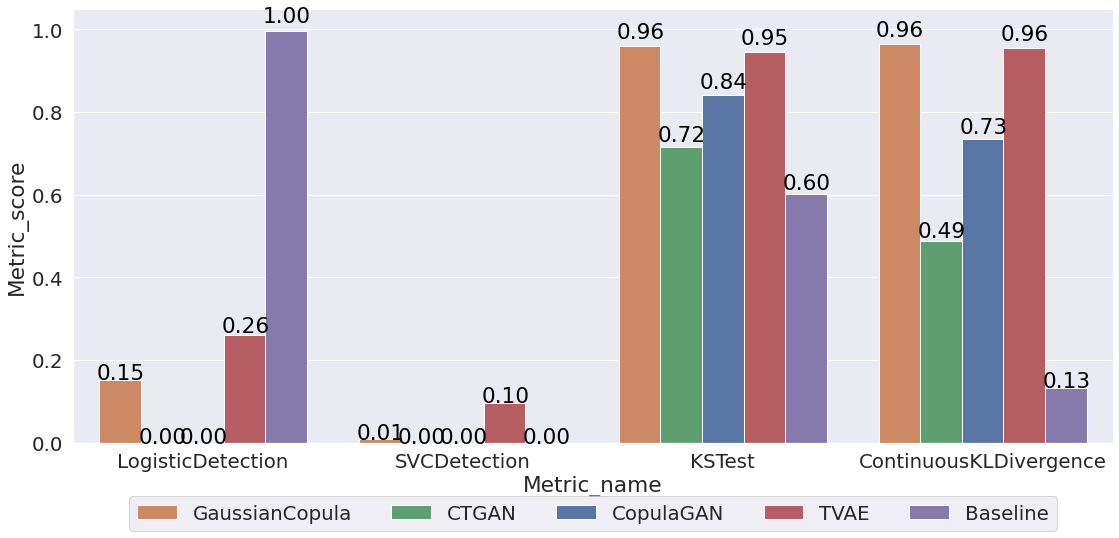

In [42]:
import matplotlib
import seaborn as sns
from matplotlib import rcParams
import matplotlib.pyplot as plt
import itertools

rcParams['figure.figsize'] = (3, 3)
matplotlib.rc('xtick', labelsize=15) 
matplotlib.rc('ytick', labelsize=15)
sns.set(font_scale=1.8)  # crazy big
plot = sns.catplot(data=gen_result_df, x="Metric_name", y="Metric_score", hue="Model_name", kind="bar", aspect=2, height=8, palette=[
    "C1", "C2", "C0", "C3", "C4"
], legend=False)
ax = plot.facet_axis(0,0)
def create_hist_values(df):
    model_names = df['Model_name'].unique()
    metric_names = df["Metric_name"].unique()
    hist_values = []
    for model, metric in itertools.product(model_names, metric_names):
        hist_values.append(df[(df['Model_name'] == model) & (df['Metric_name'] == metric)]['Metric_score'].values[0])
    return hist_values
hist_val = create_hist_values(gen_result_df)
for (p, val) in zip(ax.patches, hist_val):
    ax.text(p.get_x() - 0.01, 
            p.get_height() * 1.02, 
           '{:1.2f}'.format(val),   
            color='black', 
            rotation='horizontal', 
            size='medium')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), fancybox=True, ncol=5)
plt.tight_layout()

Оказалось, что синтетические данные, сгенерированные из многомерногог нормального распределения, не отличимы от исходных логистической регрессией. По остальным метрикам качество бейзлайна ниже (или такое же), как у остальных моделей.

В целом, качество моделей генерации кажется недостаточно высоким с точки зрения метрик LogisticDetection и SVCDetection. Кроме того, все модели на нейронных сетях требуют достаточно много времени на обучение (на это влияет размерность профилей пользователей, 320). Для дальнейшей работы было решено генерировать эмбеддинги профилей пользователей. Экспериментальное исследование эмбеддингов и их влияния на качество генерации синтетики представлено в ноутбуке movielens_embeddings.ipynb.